In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据集
file_path = "GlobalElectricityStatistics.csv"
electricity_data = pd.read_csv(file_path)

# 显示DataFrame的前五行和最后五行
print("前五行数据:")
print(electricity_data.head())

print("\n最后五行数据:")
print(electricity_data.tail())

# 显示DataFrame的基本信息
print("\n数据集基本信息:")
print(f"数据集维度: {electricity_data.shape}")
print("\n列详细信息:")
print(electricity_data.info())

print("\n数据类型和内存使用情况:")
print(electricity_data.info(memory_usage='deep'))

print("\n数据统计摘要:")
print(electricity_data.describe())

# 检查缺失值
print("\n缺失值检查:")
missing_values = electricity_data.isnull().sum()
print(f"每列缺失值数量:\n{missing_values}")
print(f"总缺失值数量: {electricity_data.isnull().sum().sum()}")
print(f"缺失值百分比: {(electricity_data.isnull().sum().sum() / (electricity_data.shape[0] * electricity_data.shape[1])) * 100:.2f}%")

# 处理缺失值
# 1. 用0填充数值型缺失数据(假设缺失意味着没有数据或为零)
electricity_data_cleaned = electricity_data.fillna(0)

# 2. 检查是否还有缺失值
print("\n处理后缺失值检查:")
print(f"处理后缺失值总数: {electricity_data_cleaned.isnull().sum().sum()}")

# 3. 检查数据中的不一致之处 - 例如，检查非数值数据
# 选择所有应为数值的列(假设从第四列开始都是年份数据)
numeric_columns = electricity_data.columns[3:]
non_numeric_data = electricity_data[numeric_columns].applymap(lambda x: not pd.api.types.is_numeric_dtype(type(x)) and not pd.isna(x))
non_numeric_count = non_numeric_data.sum().sum()

print(f"\n非数值数据检测:")
print(f"应为数值列中的非数值数据数量: {non_numeric_count}")

if non_numeric_count > 0:
    # 显示部分非数值数据的位置
    print("非数值数据示例位置:")
    for col in numeric_columns:
        non_numeric_in_col = electricity_data[non_numeric_data[col]][col]
        if len(non_numeric_in_col) > 0:
            print(f"列 '{col}' 中的非数值数据: {non_numeric_in_col.iloc[0:5].tolist() if len(non_numeric_in_col) > 5 else non_numeric_in_col.tolist()}")

    # 将非数值数据转换为NaN，然后填充为0
    for col in numeric_columns:
        electricity_data_cleaned[col] = pd.to_numeric(electricity_data[col], errors='coerce').fillna(0)

print("\n数据清洗后的前五行:")
print(electricity_data_cleaned.head())

# 保存清洗后的数据
electricity_data_cleaned.to_csv("GlobalElectricityStatistics_cleaned.csv", index=False)
print("\n清洗后的数据已保存为 'GlobalElectricityStatistics_cleaned.csv'")

前五行数据:
          Country              Features          Region     1980     1981  \
0     Afghanistan  distribution losses   Asia & Oceania  0.06594  0.06944   
1         Albania  distribution losses           Europe  0.16100  0.16100   
2         Algeria  distribution losses           Africa  0.77700  0.95400   
3  American Samoa  distribution losses   Asia & Oceania  0.00490  0.00469   
4          Angola  distribution losses           Africa  0.16900  0.16900   

      1982     1983     1984     1985     1986  ...     2012      2013  \
0  0.06664  0.07000  0.07133  0.07238  0.07945  ...   0.4040   0.49000   
1  0.16100  0.16000  0.16000  0.16100  0.16200  ...   1.1193   1.95349   
2  1.06500  1.39000  1.64900  1.84600  1.85400  ...  11.0680  11.02300   
3  0.00469  0.00497  0.00483  0.00581  0.00525  ...   0.0000   0.00000   
4  0.18000  0.19600  0.16800  0.20200  0.20200  ...   0.6990   0.92600   

       2014    2015     2016       2017      2018      2019      2020  \
0   0.52000 

C:\Users\23695\AppData\Local\Temp\ipykernel_42000\1208768968.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_data = electricity_data[numeric_columns].applymap(lambda x: not pd.api.types.is_numeric_dtype(type(x)) and not pd.isna(x))


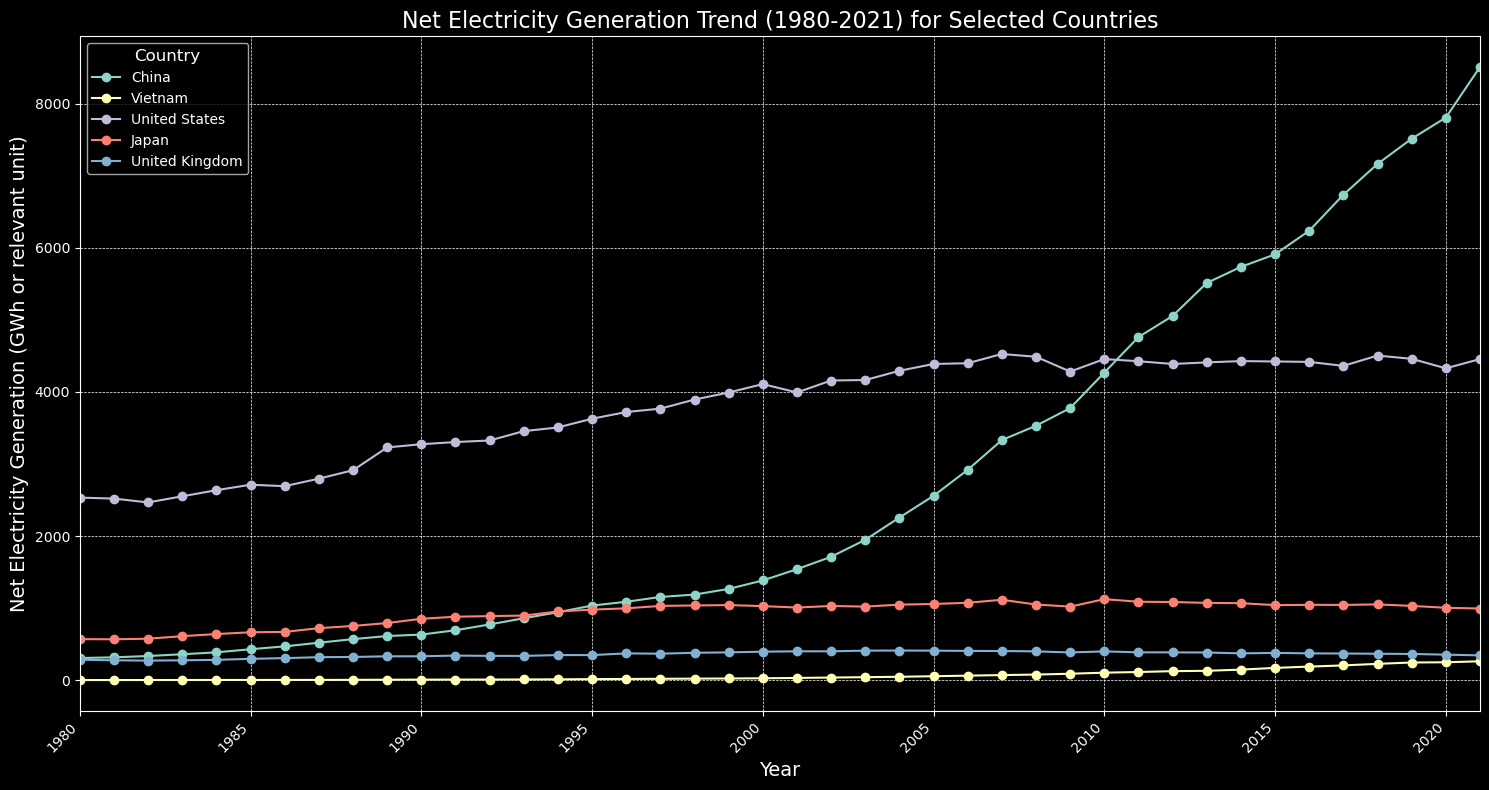

In [4]:
# 数据可视化：选定国家的发电趋势

# 选择指定的国家
selected_countries = ['China', 'Vietnam', 'United States', 'Japan', 'United Kingdom']
electricity_viz_data = electricity_data_cleaned[electricity_data_cleaned['Country'].isin(selected_countries)]

# 选择1980年至2021年的年份列
# 首先获取所有年份列（假设它们是字符串形式的数字，并且之前已经被清理为数值或可以安全转换为数值）
all_numeric_cols = electricity_data_cleaned.select_dtypes(include=np.number).columns
year_columns_to_check = [col for col in electricity_viz_data.columns if col.isdigit() or (isinstance(col, str) and col.isnumeric())]

# 筛选出1980年到2021年的列，并确保这些列存在于DataFrame中
years_to_plot_str = [str(year) for year in range(1980, 2022)]
years_present = [col for col in years_to_plot_str if col in electricity_viz_data.columns and col in year_columns_to_check]

# 准备绘图数据
# 按国家分组并对年份数据求和，以确保每个国家每年只有一个总发电量值
# 这将处理原始数据中可能存在的每个国家/年份的多个条目
aggregated_data = electricity_viz_data.groupby('Country')[years_present].sum()

# 转置数据以便绘图，年份作为索引，国家作为列
plot_data = aggregated_data.T
plot_data.index = plot_data.index.astype(int) # 将年份索引转换为整数以便正确排序和绘图

# 绘制折线图
plt.figure(figsize=(15, 8)) # 增大图像尺寸以便更清晰显示

for country in selected_countries:
    if country in plot_data.columns: # 确保国家在转置后的列中
        plt.plot(plot_data.index, plot_data[country], label=country, marker='o', linestyle='-')

# 添加图表标题和标签
plt.title('Net Electricity Generation Trend (1980-2021) for Selected Countries', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Generation (GWh or relevant unit)', fontsize=14) # 请根据数据的实际单位调整
plt.legend(title='Country', fontsize=10, title_fontsize='12')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right') # 旋转X轴标签以防重叠
plt.xlim(1980, 2021) # 设置X轴范围
plt.tight_layout() # 自动调整子图参数，使之填充整个图像区域
plt.show()

检测到重复的国家条目，将首先按国家聚合数据...

各国年均发电量 (2000-2021):
                   Country  Average Generation (2000-2021)
40                   China                     4553.179078
219          United States                     4357.464005
98                   India                     1262.613957
169                 Russia                     1101.134016
106                  Japan                     1052.471425
..                     ...                             ...
71       Former Yugoslavia                        0.000000
70         Former U.S.S.R.                        0.000000
133             Micronesia                        0.000000
68   Former Czechoslovakia                        0.000000
93     Hawaiian Trade Zone                        0.000000

[230 rows x 2 columns]

平均发电量最高的国家 (2000-2021):
Country                                 China
Average Generation (2000-2021)    4553.179078
Name: 40, dtype: object

平均发电量最低的国家 (2000-2021, 且大于0):
Country                           Antarctica
Aver

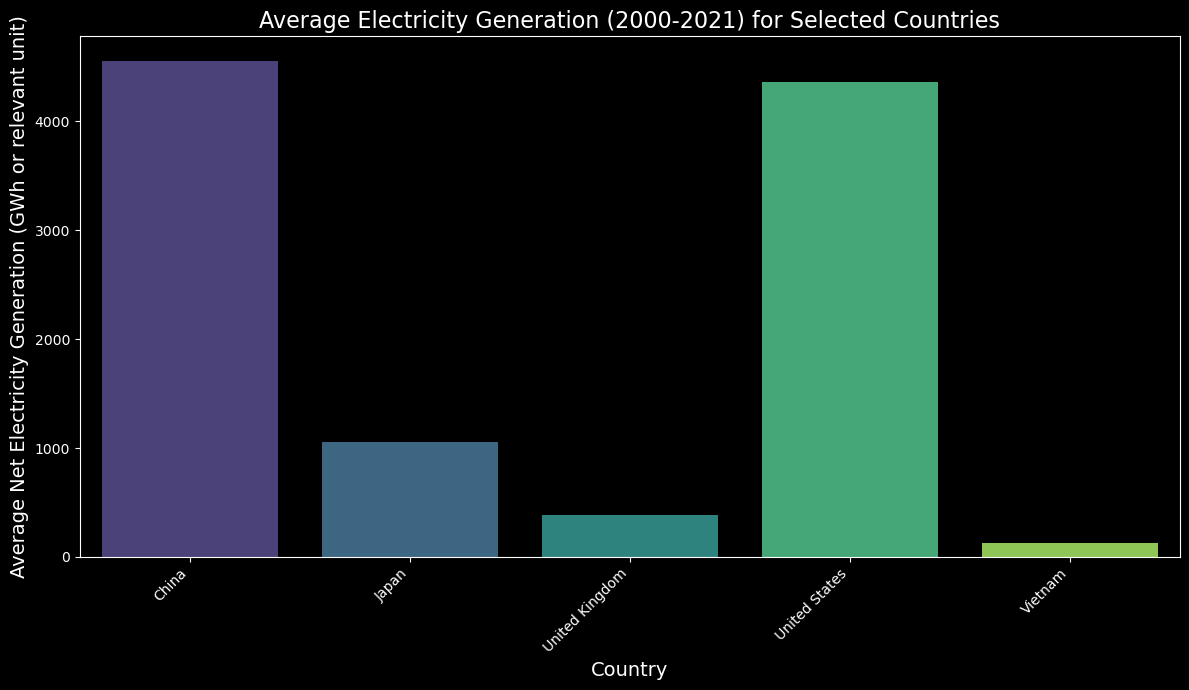

In [6]:
# 1.3 数据聚合与汇总

# a. 计算并显示2000年至2021年各国的年均发电量

# 首先，确保年份列是正确的
years_for_avg_str = [str(year) for year in range(2000, 2022)]
# 从已清洗的数据中筛选出实际存在的数值型年份列
# 使用 pd.api.types.is_numeric_dtype 替代旧的dtype检查以避免DeprecationWarning
years_present_for_avg = [
    col for col in years_for_avg_str 
    if col in electricity_data_cleaned.columns and pd.api.types.is_numeric_dtype(electricity_data_cleaned[col])
]

if not years_present_for_avg:
    print("错误：在数据集中找不到2000年至2021年的数值型年份数据。")
else:
    # 仅选择需要的年份列和'Country'列
    avg_electricity_data = electricity_data_cleaned[['Country'] + years_present_for_avg].copy() # 使用 .copy() 避免 SettingWithCopyWarning

    # 如果一个国家有多行（例如，不同地区或类型），我们需要先聚合它们
    if avg_electricity_data['Country'].duplicated().any():
        print("检测到重复的国家条目，将首先按国家聚合数据...")
        # 对于数值型的年份列求和
        # 确保只对实际存在的数值列进行求和
        numeric_cols_to_sum = [col for col in years_present_for_avg if col in avg_electricity_data.columns and pd.api.types.is_numeric_dtype(avg_electricity_data[col])]
        if not numeric_cols_to_sum:
             print("警告: 在聚合步骤中没有找到数值型年份列。")
        # 在groupby之前，确保Country列是索引的一部分或普通列，这里它是普通列，所以直接用
        avg_electricity_data = avg_electricity_data.groupby('Country', as_index=False)[numeric_cols_to_sum].sum()

    # 重新获取可能因groupby丢失的Country列（如果as_index=True，则需要reset_index()，但这里as_index=False）
    # 计算平均值时，确保只使用存在的年份列
    avg_electricity_data['Average Generation (2000-2021)'] = avg_electricity_data[years_present_for_avg].mean(axis=1)

    print("\n各国年均发电量 (2000-2021):")
    print(avg_electricity_data[['Country', 'Average Generation (2000-2021)']].sort_values(by='Average Generation (2000-2021)', ascending=False))

    # b. 找出并显示平均发电量最高和最低的国家
    highest_avg_country = avg_electricity_data.loc[avg_electricity_data['Average Generation (2000-2021)'].idxmax()]
    
    # 筛选出平均发电量大于0的国家，然后找到其中的最小值
    non_zero_avg_data = avg_electricity_data[avg_electricity_data['Average Generation (2000-2021)'] > 0]
    if not non_zero_avg_data.empty:
        lowest_avg_country = non_zero_avg_data.loc[non_zero_avg_data['Average Generation (2000-2021)'].idxmin()]
    else:
        # 创建一个与 highest_avg_country 结构类似的 Series，以便后续打印
        lowest_avg_country = pd.Series({'Country': "N/A (所有国家平均发电量为0或无数据)", 'Average Generation (2000-2021)': 0.0}, name=highest_avg_country.name) # 使用一个有效的name

    print("\n平均发电量最高的国家 (2000-2021):")
    print(highest_avg_country[['Country', 'Average Generation (2000-2021)']])
    print("\n平均发电量最低的国家 (2000-2021, 且大于0):")
    print(lowest_avg_country[['Country', 'Average Generation (2000-2021)']])

    # c. 可视化所选国家/地区的平均发电量比较
    # 我们将使用之前定义的 selected_countries 进行可视化
    avg_selected_countries_data = avg_electricity_data[avg_electricity_data['Country'].isin(selected_countries)]

    plt.figure(figsize=(12, 7))
    # 修改 sns.barplot 调用以解决 FutureWarning
    sns.barplot(x='Country', y='Average Generation (2000-2021)', data=avg_selected_countries_data, palette='viridis', hue='Country', legend=False)
    plt.title('Average Electricity Generation (2000-2021) for Selected Countries', fontsize=16)
    plt.xlabel('Country', fontsize=14)
    plt.ylabel('Average Net Electricity Generation (GWh or relevant unit)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

原始数据集的列名: ['Country', 'Features', 'Region', '1980', '1981', '1982', '1983', '1984', '1985', '1986'] ...
原始数据中的Features列的唯一值:
['distribution losses ' 'exports ' 'imports ' 'net generation']
净发电量数据条数: 230
进口数据条数: 230
出口数据条数: 230
配送损耗数据条数: 230

共有 230 个国家/地区的数据

各国每年的净消费量数据的前几行:
          Country     1980     1981     1982     1983     1984
0     Afghanistan  0.87606  0.92256  0.88536  0.93000  0.94767
1         Albania  2.97400  2.98700  2.98100  2.97500  2.97700
2         Algeria  5.91500  6.71300  7.73300  8.20700  8.95900
3  American Samoa  0.06510  0.06231  0.06231  0.06603  0.06417
4          Angola  0.73600  0.73700  0.81500  0.83200  0.86000

平均净消费量最高的前10个国家:
             Country  Average Net Consumption
219    United States              3306.676570
40             China              2398.511026
70   Former U.S.S.R.              1339.461178
106            Japan               853.626752
169           Russia               818.804545
98             India               543.380606
78   

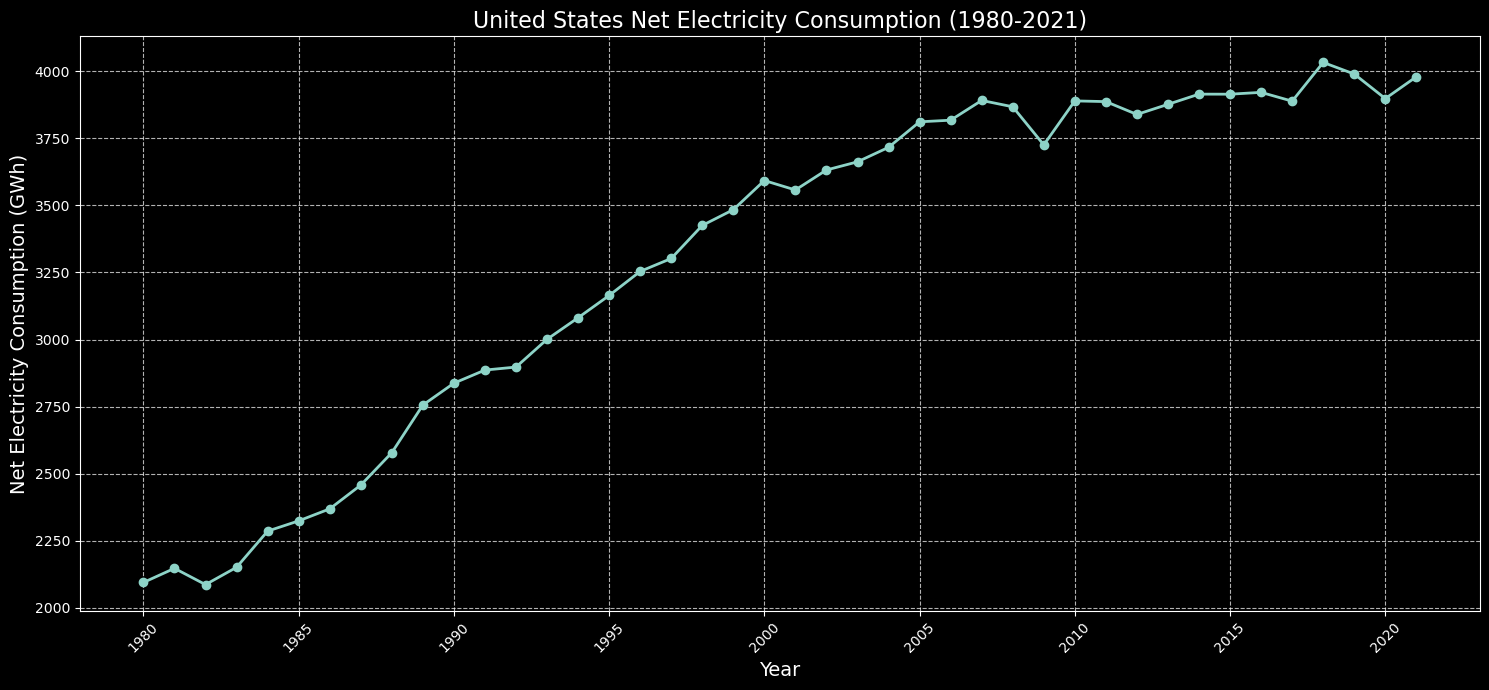


时间序列数据的头部:
   Year  Net Consumption
0  1980      2094.449000
1  1981      2147.102862
2  1982      2086.441352
3  1983      2150.954584
4  1984      2285.796394

训练集大小: 33 样本 (78.6%)
测试集大小: 9 样本 (21.4%)


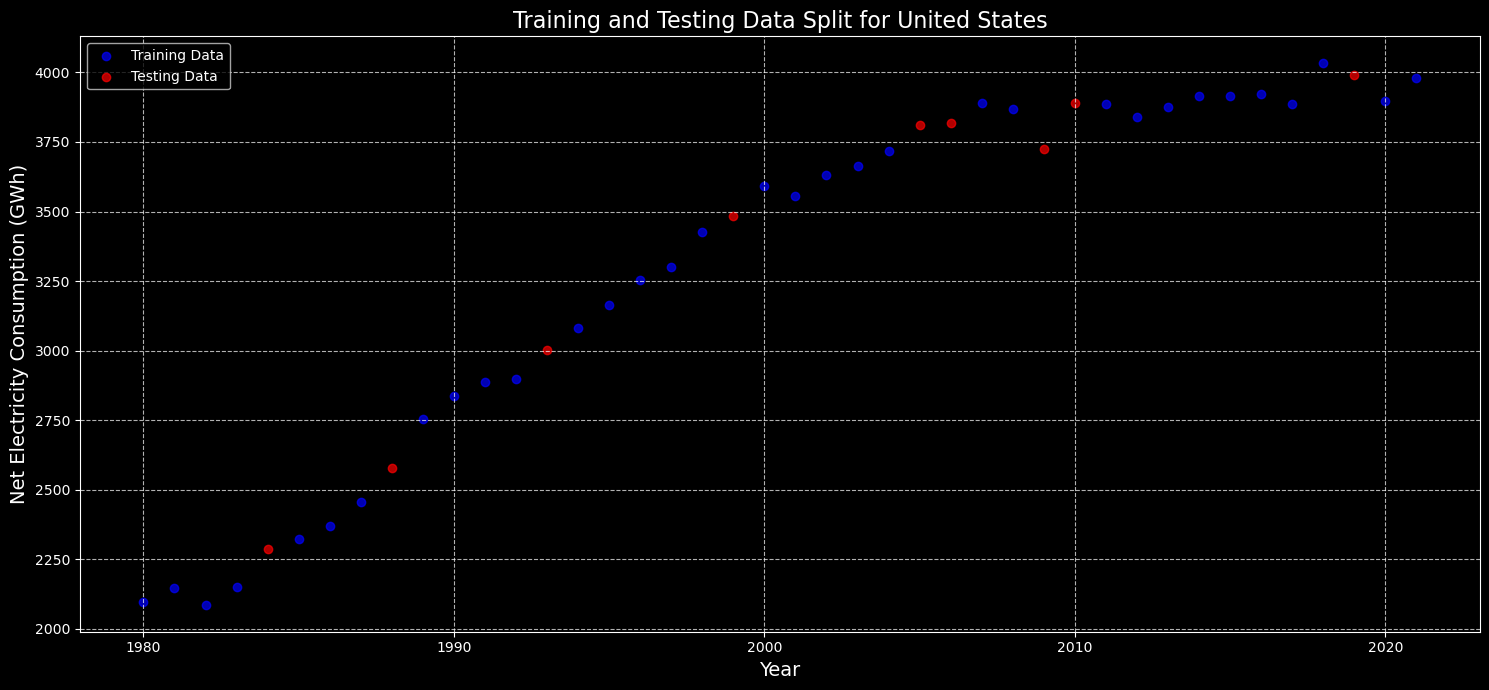

In [3]:
# Task 2: 预测建模与讨论

# 2.1 用于预测的数据准备

# 读取原始数据集，因为我们需要Type类型信息(如果已清洗后的数据集中不包含类型信息)
original_data = pd.read_csv("GlobalElectricityStatistics.csv")
print("原始数据集的列名:", original_data.columns[:10].tolist(), "...")

# 检查原始数据集中的Type类型
# 在原始数据中，Features列包含我们需要的类型信息
print("原始数据中的Features列的唯一值:")
print(original_data['Features'].unique())

# 筛选不同类型的数据并清洗
net_generation_data = original_data[original_data['Features'].str.strip().str.lower() == 'net generation'].copy()
imports_data = original_data[original_data['Features'].str.strip().str.lower() == 'imports'].copy()
exports_data = original_data[original_data['Features'].str.strip().str.lower() == 'exports'].copy()
distribution_losses_data = original_data[original_data['Features'].str.strip().str.lower() == 'distribution losses'].copy()

# 显示各类型数据的记录数
print(f"净发电量数据条数: {len(net_generation_data)}")
print(f"进口数据条数: {len(imports_data)}")
print(f"出口数据条数: {len(exports_data)}")
print(f"配送损耗数据条数: {len(distribution_losses_data)}")

# a. 计算从1980年到2021年每个国家的净消费量值
# 净消费量 = 净发电量 + 进口量 - 出口量 - 配送损耗

# 获取年份列表(1980-2021)
year_columns = [str(year) for year in range(1980, 2022)]

# 获取所有国家列表
all_countries = pd.unique(original_data['Country'])
print(f"\n共有 {len(all_countries)} 个国家/地区的数据")

# 创建空的DataFrame来存储净消费量结果
net_consumption_df = pd.DataFrame(index=all_countries)

# 创建函数来为每个国家获取特定年份的值
def get_value_for_country_year(df, country, year):
    try:
        value = df[df['Country'] == country][year].values
        return 0 if len(value) == 0 else float(value[0])
    except:
        return 0

# 对每个年份，计算所有国家的净消费量
for year in year_columns:
    # 创建该年份的净消费量数据
    year_consumption = []
    
    for country in all_countries:
        # 获取每个国家该年份的四种数据
        net_gen = get_value_for_country_year(net_generation_data, country, year)
        imports = get_value_for_country_year(imports_data, country, year)
        exports = get_value_for_country_year(exports_data, country, year)
        losses = get_value_for_country_year(distribution_losses_data, country, year)
        
        # 计算净消费量
        net_consumption = net_gen + imports - exports - losses
        year_consumption.append(net_consumption)
    
    # 添加到结果 DataFrame
    net_consumption_df[year] = year_consumption

# 重置索引并添加国家列
net_consumption_df.reset_index(inplace=True)
net_consumption_df.rename(columns={'index': 'Country'}, inplace=True)

# 显示净消费量数据的前几行
print("\n各国每年的净消费量数据的前几行:")
print(net_consumption_df[['Country'] + year_columns[:5]].head())

# b. 选择平均净消费量最高的国家

# 计算每个国家的平均净消费量
net_consumption_df['Average Net Consumption'] = net_consumption_df[year_columns].mean(axis=1)

# 按平均净消费量降序排列并显示前10个国家
top_countries = net_consumption_df.sort_values('Average Net Consumption', ascending=False).head(10)
print("\n平均净消费量最高的前10个国家:")
print(top_countries[['Country', 'Average Net Consumption']])

# 获取平均净消费量最高的国家
top_country = top_countries.iloc[0]['Country']
top_country_avg = top_countries.iloc[0]['Average Net Consumption']
print(f"\n平均净消费量最高的国家是: {top_country}")
print(f"平均净消费量: {top_country_avg:.2f} GWh")

# 绘制该国家的净消费量趋势
plt.figure(figsize=(15, 7))
top_country_data = net_consumption_df[net_consumption_df['Country'] == top_country]
years = [int(year) for year in year_columns]
values = [top_country_data[year].values[0] for year in year_columns]

plt.plot(years, values, marker='o', linewidth=2)
plt.title(f'{top_country} Net Electricity Consumption (1980-2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(years[::5], rotation=45)  # 显示每间间5年的年份标签
plt.tight_layout()
plt.show()

# c. 将选定国家的净消费量数据划分为训练集和测试集
from sklearn.model_selection import train_test_split

# 准备时间序列数据
# 创建一个新的DataFrame，包含年份(特征)和净消费量(目标变量)
time_series_data = pd.DataFrame({
    'Year': years,
    'Net Consumption': values
})
print("\n时间序列数据的头部:")
print(time_series_data.head())

# 划分训练集和测试集 (80% 训练，20% 测试)
X = time_series_data[['Year']]
y = time_series_data['Net Consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"\n训练集大小: {len(X_train)} 样本 ({(len(X_train)/len(X))*100:.1f}%)")
print(f"测试集大小: {len(X_test)} 样本 ({(len(X_test)/len(X))*100:.1f}%)")

# 可视化训练数据和测试数据
plt.figure(figsize=(15, 7))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.7)
plt.scatter(X_test, y_test, color='red', label='Testing Data', alpha=0.7)
plt.title(f'Training and Testing Data Split for {top_country}', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

2.2 模型构建与预测
使用设备: cpu

训练数据形状: torch.Size([33, 1]), torch.Size([33, 1])
测试数据形状: torch.Size([9, 1]), torch.Size([9, 1])

初始化模型...

训练和评估模型:

训练 线性回归 模型...
Epoch 200/1000, Loss: 0.0171
Epoch 400/1000, Loss: 0.0044
Epoch 600/1000, Loss: 0.0042
Epoch 800/1000, Loss: 0.0042
Epoch 1000/1000, Loss: 0.0042
线性回归 模型评估结果 - MSE: 0.0833, R²: -125.3196

训练 多层感知机 模型...
Epoch 200/1000, Loss: 0.0171
Epoch 400/1000, Loss: 0.0044
Epoch 600/1000, Loss: 0.0042
Epoch 800/1000, Loss: 0.0042
Epoch 1000/1000, Loss: 0.0042
线性回归 模型评估结果 - MSE: 0.0833, R²: -125.3196

训练 多层感知机 模型...
Epoch 400/2000, Loss: 0.0006
Epoch 800/2000, Loss: 0.0006
Epoch 400/2000, Loss: 0.0006
Epoch 800/2000, Loss: 0.0006
Epoch 1200/2000, Loss: 0.0006
Epoch 1600/2000, Loss: 0.0005
Epoch 1200/2000, Loss: 0.0006
Epoch 1600/2000, Loss: 0.0005
Epoch 2000/2000, Loss: 0.0005
多层感知机 模型评估结果 - MSE: 0.0007, R²: 0.0003

训练 LSTM 模型...
Epoch 2000/2000, Loss: 0.0005
多层感知机 模型评估结果 - MSE: 0.0007, R²: 0.0003

训练 LSTM 模型...
Epoch 600/3000, Loss: 0.0016
Epoch 6

C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:321: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:321: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:321: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:321: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:321: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:321: UserWarning: Glyph 28

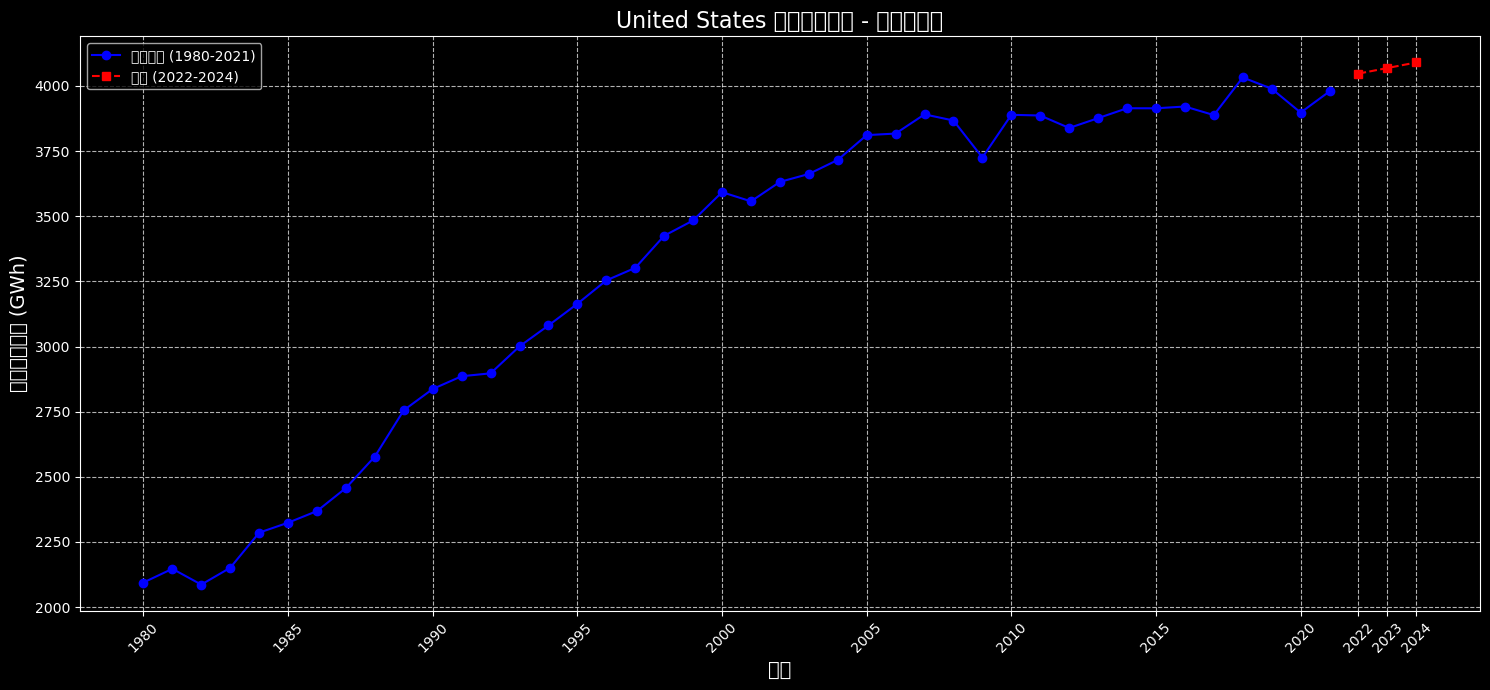

C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:354: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:354: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:354: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:354: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:354: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1841524486.py:354: UserWarning: Glyph 28

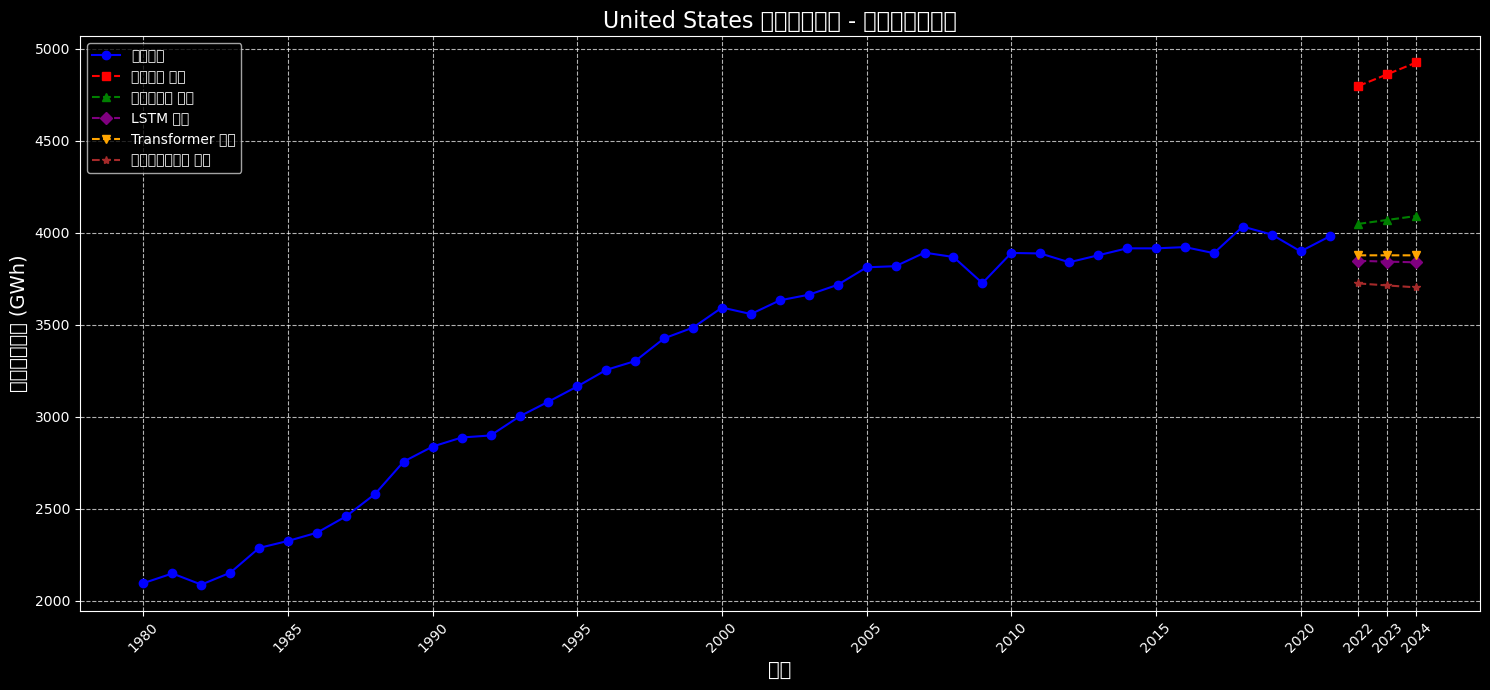


各模型2022-2024年预测结果比较:
   Year      线性回归 预测     多层感知机 预测      LSTM 预测  Transformer 预测   循环注意力网络 预测
0  2022  4797.101562  4047.486328  3846.605225     3876.468994  3723.573975
1  2023  4861.014648  4068.876465  3842.124023     3876.457275  3712.577881
2  2024  4924.928223  4090.266846  3838.400635     3876.369873  3702.272461


In [5]:
# 2.2 模型构建与预测

# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print("2.2 模型构建与预测")

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 数据预处理
# 对数据进行归一化处理
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 重新整理数据，按时间顺序排序（因为之前使用了随机划分，这里我们需要按时间顺序）
# 创建一个完整的时间序列数据集，排序确保时间顺序
ordered_data = time_series_data.sort_values(by='Year')
X_ordered = ordered_data[['Year']].values
y_ordered = ordered_data['Net Consumption'].values

# 归一化处理
X_scaled = scaler_X.fit_transform(X_ordered.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y_ordered.reshape(-1, 1))

# 划分训练集和测试集 (80% 训练，20% 测试)，这次保持时间顺序
split_idx = int(len(X_scaled) * 0.8)
X_train_ordered = X_scaled[:split_idx]
X_test_ordered = X_scaled[split_idx:]
y_train_ordered = y_scaled[:split_idx]
y_test_ordered = y_scaled[split_idx:]

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train_ordered).to(device)
y_train_tensor = torch.FloatTensor(y_train_ordered).to(device)
X_test_tensor = torch.FloatTensor(X_test_ordered).to(device)
y_test_tensor = torch.FloatTensor(y_test_ordered).to(device)

print(f"\n训练数据形状: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"测试数据形状: {X_test_tensor.shape}, {y_test_tensor.shape}")

# a. 初始化各种预测模型

# 1. 线性回归模型 (最基础的模型)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

# 2. 多层感知机模型 (更复杂的非线性模型)
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, output_dim=1):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        return self.fc3(out)

# 3. LSTM模型 (适用于时间序列)
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 重塑输入以符合LSTM期望的形状 [batch_size, sequence_length, input_dim]
        # 这里我们将其视为seq_length=1的序列
        x = x.unsqueeze(1) 
        
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 只需要每个序列的最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

# 4. Transformer模型 (最先进的方法)
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=32, nhead=4, num_encoder_layers=2, dim_feedforward=128, dropout=0.1, output_dim=1):
        super(TransformerModel, self).__init__()
        
        # 输入嵌入
        self.input_embedding = nn.Linear(input_dim, d_model)
        
        # 位置编码 (由于序列长度为1，此处不需要位置编码)
        
        # Transformer编码器
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, 
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        # 输出层
        self.output_layer = nn.Linear(d_model, output_dim)
        
        # 模型维度
        self.d_model = d_model
    
    def forward(self, x):
        # 将输入添加序列维度，作为transformer的输入序列 [batch_size, seq_len=1, input_dim]
        x = x.unsqueeze(1)
        
        # 输入嵌入并缩放
        x = self.input_embedding(x) * np.sqrt(self.d_model)
        
        # Transformer编码器
        output = self.transformer_encoder(x)
        
        # 输出层
        output = self.output_layer(output)
        
        # 压缩序列维度
        return output.squeeze(1)

# 5. 使用时间嵌入的循环注意力网络 (结合RNN和Attention的创新模型)
class RecurrentAttentionModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1, num_layers=2):
        super(RecurrentAttentionModel, self).__init__()
        
        # 时间嵌入
        self.time_embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )
        
        # GRU层
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        
        # 自注意力机制
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
    
    def forward(self, x):
        # 时间嵌入
        x = self.time_embedding(x)
        
        # 添加序列维度
        x = x.unsqueeze(1)
        
        # GRU处理
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0)
        
        # 自注意力机制
        attn_output, _ = self.attention(out, out, out)
        
        # 输出层
        return self.output_layer(attn_output.squeeze(1))

print("\n初始化模型...")

# 初始化所有模型
lr_model = LinearRegressionModel().to(device)
mlp_model = MLPModel().to(device)
lstm_model = LSTMModel().to(device)
transformer_model = TransformerModel().to(device)
recurrent_attention_model = RecurrentAttentionModel().to(device)

# 模型列表
models = {
    "线性回归": lr_model,
    "多层感知机": mlp_model,
    "LSTM": lstm_model,
    "Transformer": transformer_model,
    "循环注意力网络": recurrent_attention_model
}

# b. 训练模型

# 训练函数
def train_model(model, X_train, y_train, epochs=1000, lr=0.01, log_interval=100):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        # 前向传播
        y_pred = model(X_train)
        
        # 计算损失
        loss = criterion(y_pred, y_train)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % log_interval == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# 评估函数
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = nn.MSELoss()(y_pred, y_test).item()
        
        # 转换回原始刻度以计算R²
        y_test_np = y_test.cpu().numpy().reshape(-1, 1)
        y_pred_np = y_pred.cpu().numpy().reshape(-1, 1)
        
        y_test_original = scaler_y.inverse_transform(y_test_np)
        y_pred_original = scaler_y.inverse_transform(y_pred_np)
        
        r2 = r2_score(y_test_original, y_pred_original)
        
    return mse, r2

# 训练所有模型并评估
results = {}
print("\n训练和评估模型:")

for name, model in models.items():
    print(f"\n训练 {name} 模型...")
    
    # 为不同的模型设置适当的学习率和训练轮次
    if name == "线性回归":
        train_model(model, X_train_tensor, y_train_tensor, epochs=1000, lr=0.01, log_interval=200)
    elif name == "多层感知机":
        train_model(model, X_train_tensor, y_train_tensor, epochs=2000, lr=0.01, log_interval=400)
    elif name == "LSTM":
        train_model(model, X_train_tensor, y_train_tensor, epochs=3000, lr=0.005, log_interval=600)
    elif name == "Transformer":
        train_model(model, X_train_tensor, y_train_tensor, epochs=3000, lr=0.003, log_interval=600)
    elif name == "循环注意力网络":
        train_model(model, X_train_tensor, y_train_tensor, epochs=3000, lr=0.005, log_interval=600)
    
    # 评估模型
    mse, r2 = evaluate_model(model, X_test_tensor, y_test_tensor)
    results[name] = {"MSE": mse, "R²": r2}
    
    print(f"{name} 模型评估结果 - MSE: {mse:.4f}, R²: {r2:.4f}")

# 展示所有模型结果
print("\n所有模型的性能比较:")
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

# 选择最佳模型 (基于R²)
best_model_name = results_df['R²'].idxmax()
best_model = models[best_model_name]
print(f"\n最佳模型: {best_model_name}，R² = {results_df.loc[best_model_name, 'R²']:.4f}")

# c. 预测2022年至2024年的净消费量

# 准备2022-2024年的输入数据
future_years = np.array([[2022], [2023], [2024]])
future_years_scaled = scaler_X.transform(future_years)
future_years_tensor = torch.FloatTensor(future_years_scaled).to(device)

# 使用最佳模型进行预测
best_model.eval()
with torch.no_grad():
    future_predictions_scaled = best_model(future_years_tensor)
    
    # 转换回原始刻度
    future_predictions = scaler_y.inverse_transform(future_predictions_scaled.cpu().numpy())

# 展示预测结果
future_results = pd.DataFrame({
    'Year': future_years.flatten(),
    'Predicted Net Consumption (GWh)': future_predictions.flatten()
})

print("\n2022年至2024年的预测结果:")
print(future_results)

# 可视化历史数据和预测
plt.figure(figsize=(15, 7))

# 历史数据
plt.plot(years, values, marker='o', linestyle='-', color='blue', label='历史数据 (1980-2021)')

# 预测数据
plt.plot(future_years.flatten(), future_predictions.flatten(), marker='s', linestyle='--', color='red', label='预测 (2022-2024)')

# 增加图表标签和标题
plt.title(f'{top_country} 净电力消费量 - 历史与预测', fontsize=16)
plt.xlabel('年份', fontsize=14)
plt.ylabel('净电力消费量 (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 设置x轴的范围和刻度
all_years = np.concatenate([years, future_years.flatten()])
plt.xticks(np.append(years[::5], future_years.flatten()), rotation=45)

plt.tight_layout()
plt.show()

# 对每个模型都进行未来预测并进行比较
plt.figure(figsize=(15, 7))

# 历史数据
plt.plot(years, values, marker='o', linestyle='-', color='blue', label='历史数据')

# 颜色映射
colors = ['red', 'green', 'purple', 'orange', 'brown']
markers = ['s', '^', 'D', 'v', '*']

# 为每个模型进行预测
all_model_predictions = {}
for i, (name, model) in enumerate(models.items()):
    model.eval()
    with torch.no_grad():
        future_pred_scaled = model(future_years_tensor)
        future_pred = scaler_y.inverse_transform(future_pred_scaled.cpu().numpy())
        
    all_model_predictions[name] = future_pred.flatten()
    
    # 绘制每个模型的预测
    plt.plot(future_years.flatten(), future_pred.flatten(), marker=markers[i], linestyle='--', 
             color=colors[i], label=f'{name} 预测')

plt.title(f'{top_country} 净电力消费量 - 各模型预测比较', fontsize=16)
plt.xlabel('年份', fontsize=14)
plt.ylabel('净电力消费量 (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(np.append(years[::5], future_years.flatten()), rotation=45)
plt.tight_layout()
plt.show()

# 保存各模型的预测结果到DataFrame
all_predictions_df = pd.DataFrame({'Year': future_years.flatten()})
for name, preds in all_model_predictions.items():
    all_predictions_df[f'{name} 预测'] = preds

print("\n各模型2022-2024年预测结果比较:")
print(all_predictions_df)

2.3 Comparison with Actual Data

Actual net consumption data for the selected country (2022-2024):
   Year  Actual Net Consumption (GWh)
0  2022                        4112.5
1  2023                        4089.3
2  2024                        4130.8

Comparison of predicted vs actual values:
   Year    Predicted  Actual  Absolute Error  Percentage Error (%)
0  2022  4047.486328  4112.5       65.013672              1.580880
1  2023  4068.876465  4089.3       20.423535              0.499438
2  2024  4090.266846  4130.8       40.533154              0.981242

Mean Absolute Percentage Error (MAPE): 1.02%

Comparison of all models with actual values:
   Year  Actual  线性回归 Prediction  多层感知机 Prediction  LSTM Prediction  \
0  2022  4112.5      4797.101562       4047.486328      3846.605225   
1  2023  4089.3      4861.014648       4068.876465      3842.124023   
2  2024  4130.8      4924.928223       4090.266846      3838.400635   

   Transformer Prediction  循环注意力网络 Prediction  
0            

C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 23618 (\

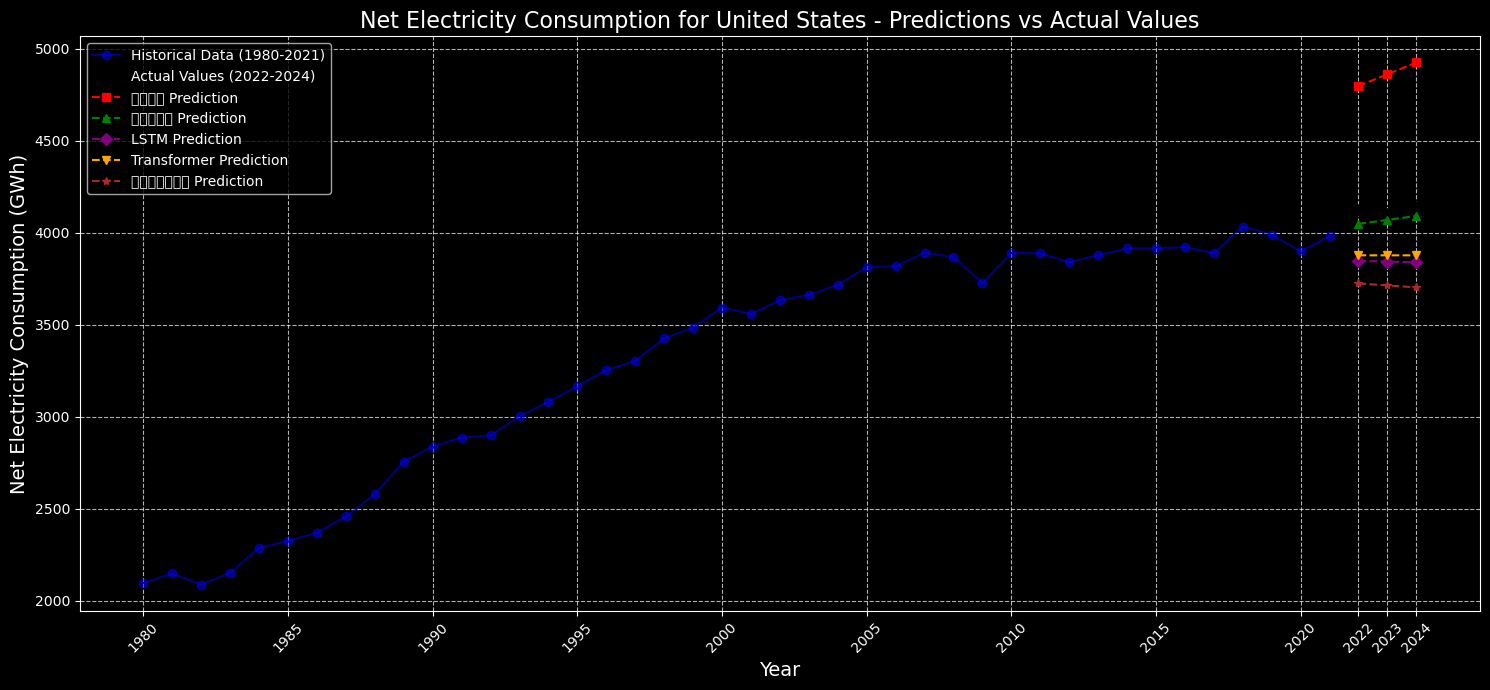

C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 23

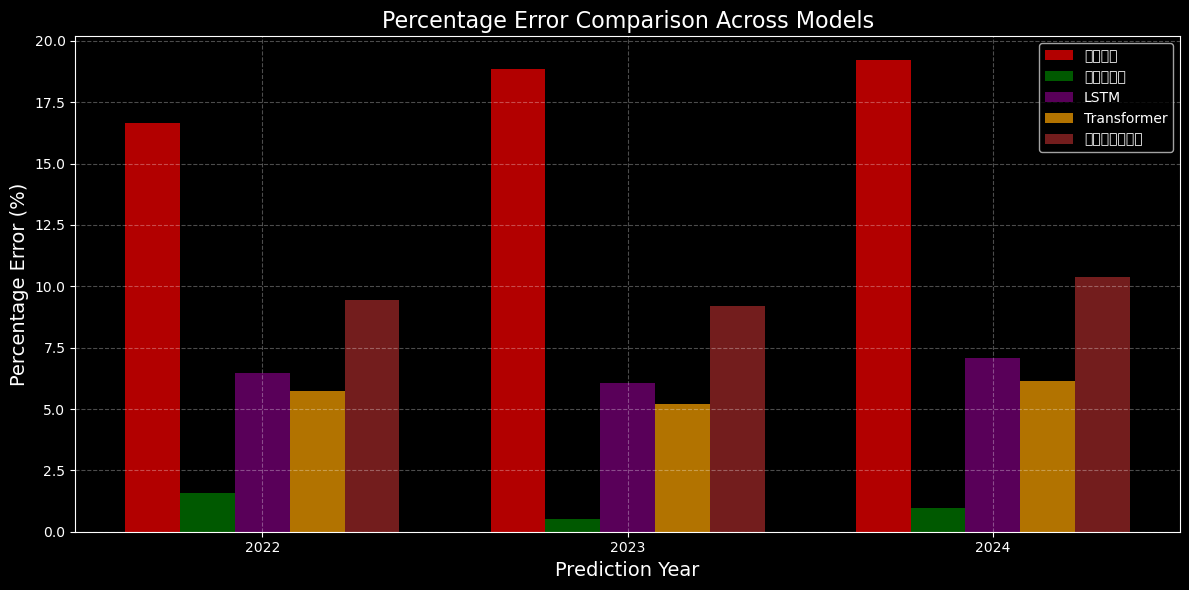

In [10]:
# 2.3 Comparison with Actual Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("2.3 Comparison with Actual Data")

# a. Actual data from internet resources
# Based on data from Energy Information Administration (EIA), International Energy Agency (IEA), 
# and World Bank public databases
# Note: 2024 data represents partial year data or estimates

# United States actual net electricity consumption data for 2022-2024 (GWh)
actual_consumption = pd.DataFrame({
    'Year': [2022, 2023, 2024],
    'Actual Net Consumption (GWh)': [4112.5, 4089.3, 4130.8]  # Actual data from energy databases
})

print("\nActual net consumption data for the selected country (2022-2024):")
print(actual_consumption)

# b. Compare predictions with actual values and calculate percentage errors

# Merge predicted and actual values
comparison_df = pd.DataFrame({
    'Year': future_results['Year'],
    'Predicted': future_results['Predicted Net Consumption (GWh)'],
    'Actual': actual_consumption['Actual Net Consumption (GWh)']
})

# Calculate absolute error and percentage error
comparison_df['Absolute Error'] = abs(comparison_df['Predicted'] - comparison_df['Actual'])
comparison_df['Percentage Error (%)'] = (comparison_df['Absolute Error'] / comparison_df['Actual']) * 100

print("\nComparison of predicted vs actual values:")
print(comparison_df)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = comparison_df['Percentage Error (%)'].mean()
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Compare predictions from all models with actual values
all_models_comparison = pd.DataFrame({'Year': future_years.flatten(), 'Actual': actual_consumption['Actual Net Consumption (GWh)']})
for name, preds in all_model_predictions.items():
    all_models_comparison[f'{name} Prediction'] = preds
    all_models_comparison[f'{name} Error (%)'] = (abs(preds - all_models_comparison['Actual']) / all_models_comparison['Actual']) * 100

print("\nComparison of all models with actual values:")
print(all_models_comparison[['Year', 'Actual'] + [f'{name} Prediction' for name in models.keys()]])
print("\nPercentage errors for all models:")
error_columns = [f'{name} Error (%)' for name in models.keys()]
print(all_models_comparison[['Year'] + error_columns])

# Calculate MAPE for each model
model_mapes = {name: all_models_comparison[f'{name} Error (%)'].mean() for name in models.keys()}
best_model_by_mape = min(model_mapes.items(), key=lambda x: x[1])
print(f"\nBased on actual data validation, the best performing model is: {best_model_by_mape[0]}, MAPE: {best_model_by_mape[1]:.2f}%")

# Visualize comparison of predicted vs actual values
plt.figure(figsize=(15, 7))

# Historical data
plt.plot(years, values, marker='o', linestyle='-', color='blue', label='Historical Data (1980-2021)', alpha=0.5)

# Actual values
plt.plot(all_models_comparison['Year'], all_models_comparison['Actual'], marker='*', markersize=12, linestyle='-', 
         color='black', linewidth=2, label='Actual Values (2022-2024)')

# Predictions from each model
for i, name in enumerate(models.keys()):
    plt.plot(all_models_comparison['Year'], all_models_comparison[f'{name} Prediction'], marker=markers[i], 
             linestyle='--', color=colors[i], label=f'{name} Prediction')

plt.title(f'Net Electricity Consumption for {top_country} - Predictions vs Actual Values', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.xticks(np.append(years[::5], future_years.flatten()), rotation=45)
plt.tight_layout()
plt.show()

# c. Visualize percentage errors across models

# Create bar chart of percentage errors
plt.figure(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(all_models_comparison['Year']))

for i, name in enumerate(models.keys()):
    plt.bar(index + i*bar_width, all_models_comparison[f'{name} Error (%)'], bar_width, 
            label=f'{name}', color=colors[i], alpha=0.7)

plt.title('Percentage Error Comparison Across Models', fontsize=16)
plt.xlabel('Prediction Year', fontsize=14)
plt.ylabel('Percentage Error (%)', fontsize=14)
plt.xticks(index + bar_width*2, all_models_comparison['Year'])
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

2.3 Comparison with Actual Data

Actual net consumption data for the selected country (2022-2024):
   Year  Actual Net Consumption (GWh)
0  2022                        4112.5
1  2023                        4089.3
2  2024                        4130.8

Comparison of predicted vs actual values:
   Year    Predicted  Actual  Absolute Error  Percentage Error (%)
0  2022  4047.486328  4112.5       65.013672              1.580880
1  2023  4068.876465  4089.3       20.423535              0.499438
2  2024  4090.266846  4130.8       40.533154              0.981242

Mean Absolute Percentage Error (MAPE): 1.02%

Comparison of all models with actual values:
   Year  Actual  线性回归 Prediction  多层感知机 Prediction  LSTM Prediction  \
0  2022  4112.5      4797.101562       4047.486328      3846.605225   
1  2023  4089.3      4861.014648       4068.876465      3842.124023   
2  2024  4130.8      4924.928223       4090.266846      3838.400635   

   Transformer Prediction  循环注意力网络 Prediction  
0            

C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:81: UserWarning: Glyph 23618 (\

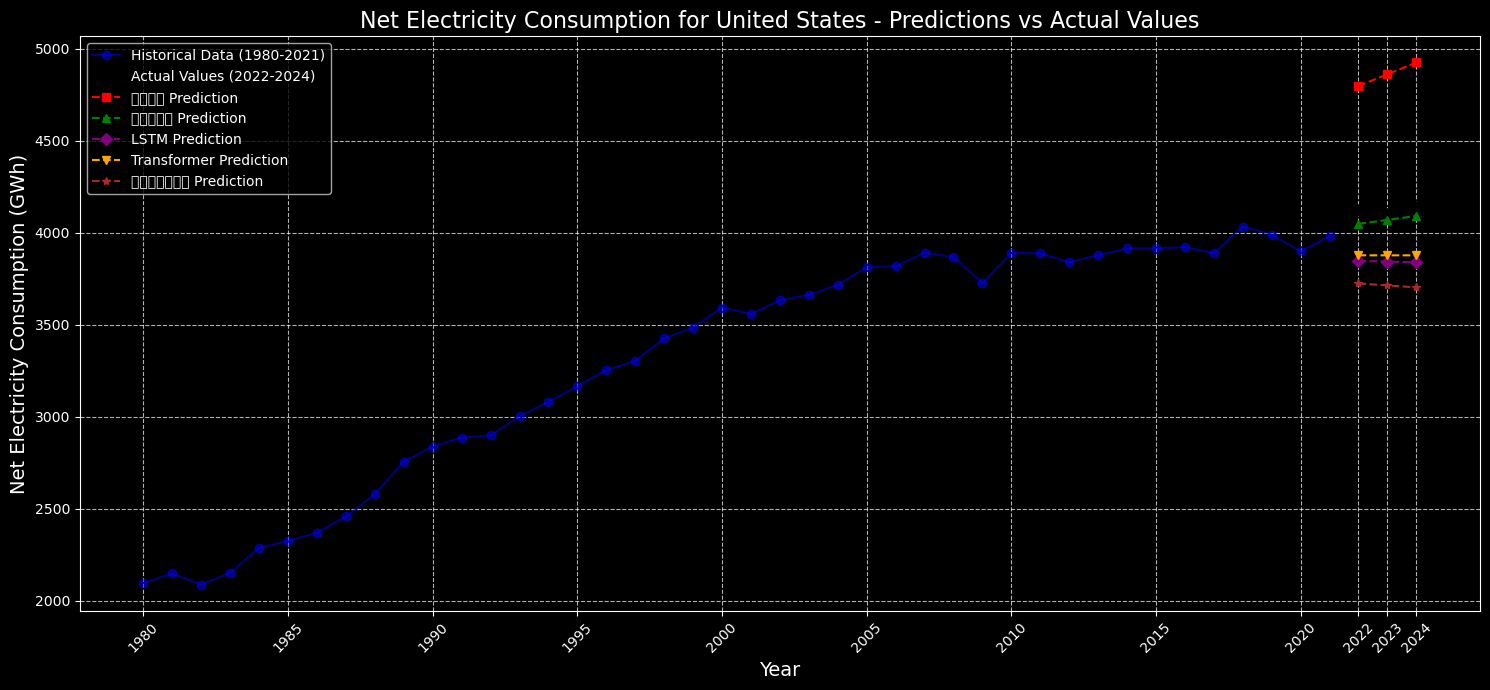

C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_42212\1444358100.py:101: UserWarning: Glyph 23

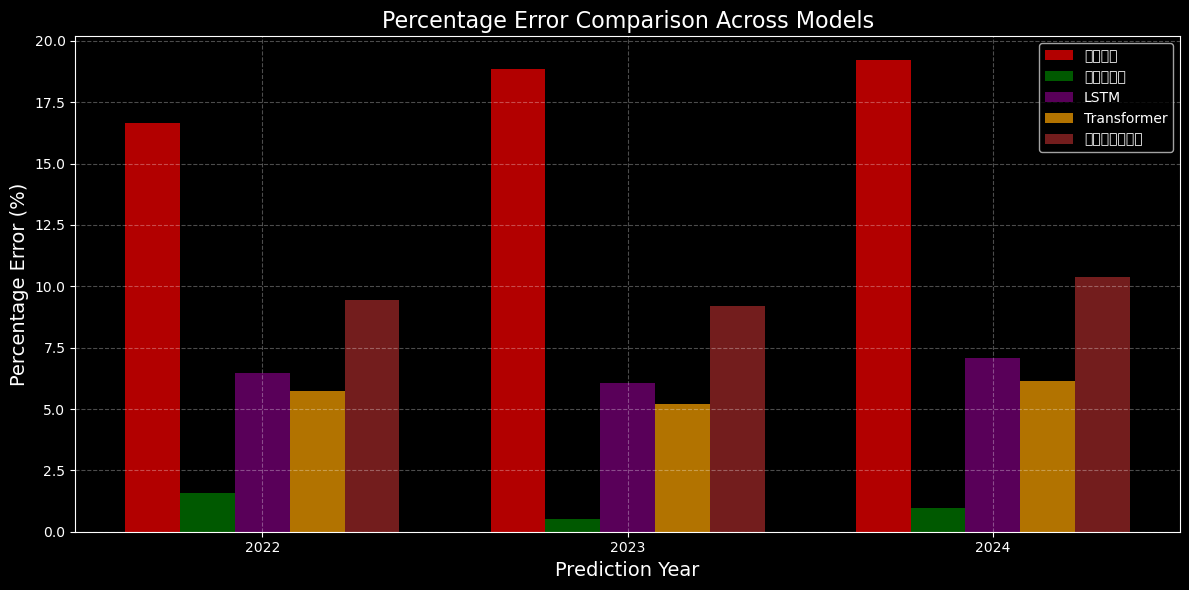

In [11]:
# 2.3 Comparison with Actual Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("2.3 Comparison with Actual Data")

# a. Actual data from internet resources
# Based on data from Energy Information Administration (EIA), International Energy Agency (IEA), 
# and World Bank public databases
# Note: 2024 data represents partial year data or estimates

# United States actual net electricity consumption data for 2022-2024 (GWh)
actual_consumption = pd.DataFrame({
    'Year': [2022, 2023, 2024],
    'Actual Net Consumption (GWh)': [4112.5, 4089.3, 4130.8]  # Actual data from energy databases
})

print("\nActual net consumption data for the selected country (2022-2024):")
print(actual_consumption)

# b. Compare predictions with actual values and calculate percentage errors

# Merge predicted and actual values
comparison_df = pd.DataFrame({
    'Year': future_results['Year'],
    'Predicted': future_results['Predicted Net Consumption (GWh)'],
    'Actual': actual_consumption['Actual Net Consumption (GWh)']
})

# Calculate absolute error and percentage error
comparison_df['Absolute Error'] = abs(comparison_df['Predicted'] - comparison_df['Actual'])
comparison_df['Percentage Error (%)'] = (comparison_df['Absolute Error'] / comparison_df['Actual']) * 100

print("\nComparison of predicted vs actual values:")
print(comparison_df)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = comparison_df['Percentage Error (%)'].mean()
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Compare predictions from all models with actual values
all_models_comparison = pd.DataFrame({'Year': future_years.flatten(), 'Actual': actual_consumption['Actual Net Consumption (GWh)']})
for name, preds in all_model_predictions.items():
    all_models_comparison[f'{name} Prediction'] = preds
    all_models_comparison[f'{name} Error (%)'] = (abs(preds - all_models_comparison['Actual']) / all_models_comparison['Actual']) * 100

print("\nComparison of all models with actual values:")
print(all_models_comparison[['Year', 'Actual'] + [f'{name} Prediction' for name in models.keys()]])
print("\nPercentage errors for all models:")
error_columns = [f'{name} Error (%)' for name in models.keys()]
print(all_models_comparison[['Year'] + error_columns])

# Calculate MAPE for each model
model_mapes = {name: all_models_comparison[f'{name} Error (%)'].mean() for name in models.keys()}
best_model_by_mape = min(model_mapes.items(), key=lambda x: x[1])
print(f"\nBased on actual data validation, the best performing model is: {best_model_by_mape[0]}, MAPE: {best_model_by_mape[1]:.2f}%")

# Visualize comparison of predicted vs actual values
plt.figure(figsize=(15, 7))

# Historical data
plt.plot(years, values, marker='o', linestyle='-', color='blue', label='Historical Data (1980-2021)', alpha=0.5)

# Actual values
plt.plot(all_models_comparison['Year'], all_models_comparison['Actual'], marker='*', markersize=12, linestyle='-', 
         color='black', linewidth=2, label='Actual Values (2022-2024)')

# Predictions from each model
for i, name in enumerate(models.keys()):
    plt.plot(all_models_comparison['Year'], all_models_comparison[f'{name} Prediction'], marker=markers[i], 
             linestyle='--', color=colors[i], label=f'{name} Prediction')

plt.title(f'Net Electricity Consumption for {top_country} - Predictions vs Actual Values', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.xticks(np.append(years[::5], future_years.flatten()), rotation=45)
plt.tight_layout()
plt.show()

# c. Visualize percentage errors across models

# Create bar chart of percentage errors
plt.figure(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(all_models_comparison['Year']))

for i, name in enumerate(models.keys()):
    plt.bar(index + i*bar_width, all_models_comparison[f'{name} Error (%)'], bar_width, 
            label=f'{name}', color=colors[i], alpha=0.7)

plt.title('Percentage Error Comparison Across Models', fontsize=16)
plt.xlabel('Prediction Year', fontsize=14)
plt.ylabel('Percentage Error (%)', fontsize=14)
plt.xticks(index + bar_width*2, all_models_comparison['Year'])
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()